In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os

In [2]:
def initialize_c_corner_deleted(num_grid_, num_side_, scale_factor_):
    c = np.zeros((num_grid_+2, num_grid_+2, num_side_))
        
    # setting side value
    for i in range(num_grid_-2):
        c[0+1, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of upper side
        c[0+1, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of upper side
        c[0+1, 0+1+1+i, 2] = 0.25/scale_factor_ # down side of upper side
    for i in range(num_grid_-2):
        c[num_grid_, 0+1+1+i, 1] = 0.375/scale_factor_ # right side of bottom side
        c[num_grid_, 0+1+1+i, 3] = 0.375/scale_factor_ # left side of bottom side
        c[num_grid_, 0+1+1+i, 0] = 0.25/scale_factor_ # upper side of bottom side
    for i in range(num_grid_-2):
        c[0+1+1+i, num_grid_, 0] = 0.375/scale_factor_ # upper side of right side
        c[0+1+1+i, num_grid_, 2] = 0.375/scale_factor_ # bottom side of right side
        c[0+1+1+i, num_grid_, 3] = 0.25/scale_factor_ # left side of right side
    for i in range(num_grid_-2):
        c[0+1+1+i, 0+1, 0] = 0.375/scale_factor_ # upper side of left side
        c[0+1+1+i, 0+1, 2] = 0.375/scale_factor_ # bottom side of left side
        c[0+1+1+i, 0+1, 1] = 0.25/scale_factor_ # right side of left side
    
    # connecting corner
    c[1, 1, 1] = c[1, 1, 2] = 0.375/scale_factor_ # upper left
    c[1, num_grid_, 2] = c[1, num_grid_, 3] = 0.375/scale_factor_ # upper right
    c[num_grid_, 1, 0] = c[num_grid_, 1, 1] = 0.375/scale_factor_ # bottom left
    c[num_grid_, num_grid_, 0] = c[num_grid_, num_grid_, 3] = 0.375/scale_factor_ # bottom right
    
    # setting most of the grid
    for i in range(num_grid_-2):
        for j in range(num_grid_-2):
            for k in range(4):
                c[i+2, j+2, k] = 0.25/scale_factor_
    
    #print(c)
    return c
    
c = initialize_c_corner_deleted(9, 4, 100)
#print(c)

In [3]:
def gain_function_(z, alpha):
    return alpha * math.log(1 + math.exp(z/alpha))

def single_population_rate_model_(E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, Ext_input, t_fac, t_d, t_th, thre_effi, U, dt):
    du = (U - u_t) / t_fac + U * (1 - u_t) * E_t    
    dE = (- E_t + gain_function_((J * u_t * x_t * E_t + E_0_default + Ext_input - thre_effi * z_t), alpha)) / tau
    dx = (1 - x_t) / t_d - u_t * x_t * E_t
    dz = (E_t - z_t)/t_th
    
    E_t_ = E_t + dE * dt
    x_t_ = x_t + dx * dt
    u_t_ = u_t + du * dt
    z_t_ = z_t + dz * dt
    return E_t_, u_t_, x_t_, z_t_

def init_dynamical_variable_and_time(num_grid, T, E_ini, u_ini, x_ini, z_ini):
    time = np.zeros(int(T))
    E_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    u_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    x_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    z_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
    
    # E_t[time_index, grid_index_i, grid_index_j]
    E_t[0, :, :] = E_ini
    # E_t[:, 0, :] and E_t[:, num_grid + 1, :] and E_t[:, :, 0] and E_t[:, :, num_grid + 1] is boundary. 
    # this value has no physical meaning.
    if E_ini != 0:
        E_t[:, 0, :] = E_t[:, num_grid + 1, :] = E_t[:, :, 0] = E_t[:, :, num_grid + 1] = 0
    
    u_t[0, :, :] = u_ini
    if u_ini != 0:
        u_t[:, 0, :] = u_t[:, num_grid + 1, :] = u_t[:, :, 0] = u_t[:, :, num_grid + 1] = 0
    x_t[0, :, :] = x_ini
    if x_ini != 0:
        x_t[:, 0, :] = x_t[:, num_grid + 1, :] = x_t[:, :, 0] = x_t[:, :, num_grid + 1] = 0
    z_t[0, :, :] = z_ini
    #print(E_t, u_t, x_t, z_t)
    return time, E_t, u_t, x_t, z_t

In [115]:
def start_simulation(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt):
    print("starting sinulation\ngrid size {}*{} simulation time {}sec".format(num_grid, num_grid, int(T*dt)))
    print("parameters are following\ntau {} t_fac {} t_d {} t_th {} U {}".format(tau, t_fac, t_d, t_th, U))
    print("J {} alpha {} thre_effi {}".format(J, alpha, thre_effi))
    print(E_t[0,:,:])
    for i in range(int(T) - 1):
        time[i+1] = i * dt
        for grid_index_i in range(num_grid):
            for grid_index_j in range(num_grid):
                """
                # this is correct
                E_t[i+1, grid_index_i+1, grid_index_j+1] = (c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1]\
                                         +c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1]\
                                         +c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1]\
                                        +c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1])
                """
                
                """
                this is correct
                print("{} = {} + {} + {} + {}".format(E_t[i+1, grid_index_i+1, grid_index_j+1]\
                                     , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1]\
                                     , c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1]\
                                     , c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1]\
                                     , c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1]))
                """
                
                E_t[i+1, grid_index_i+1, grid_index_j+1], u_t[i+1, grid_index_i+1, grid_index_j+1], x_t[i+1, grid_index_i+1, grid_index_j+1]\
                , z_t[i+1, grid_index_i+1, grid_index_j+1] \
                = single_population_rate_model_(E_t[i, grid_index_i+1, grid_index_j+1], u_t[i, grid_index_i+1, grid_index_j+1]\
                                        , x_t[i, grid_index_i+1, grid_index_j+1], z_t[i, grid_index_i+1, grid_index_j+1]\
                                        , J, alpha, tau, E_0_default\
                                        , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1] * u_t[i, grid_index_i+1-1, grid_index_j+1] * x_t[i, grid_index_i+1-1, grid_index_j+1]\
                                         +c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1] * u_t[i, grid_index_i+1, grid_index_j+1+1] * x_t[i, grid_index_i+1, grid_index_j+1+1]\
                                         +c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1] * u_t[i, grid_index_i+1+1, grid_index_j+1] * x_t[i, grid_index_i+1+1, grid_index_j+1]\
                                        +c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i-1, grid_index_i+1, grid_index_j+1-1] * u_t[i-1, grid_index_i+1, grid_index_j+1-1] * x_t[i-1, grid_index_i+1, grid_index_j+1-1]
                                        , t_fac, t_d, t_th, thre_effi, U, dt)
        # setting corner value
        E_t[i+1, 1, 1], x_t[i+1, 1, 1], u_t[i+1, 1, 1] = (E_t[i+1, 1, 2] + E_t[i+1, 2, 1])/2, (x_t[i+1, 1, 2] + x_t[i+1, 2, 1])/2, (u_t[i+1, 1, 2] + u_t[i+1, 2, 1])/2 # upper left 
        #print("E_t[{}, 1, 1] = ({} + {})/2 = {}".format(i+1, E_t[i+1, 1, 2], E_t[i+1, 2, 1], E_t[i+1, 1, 1]))
        E_t[i+1, 1, num_grid], x_t[i+1, 1, num_grid], u_t[i+1, 1, num_grid] = (E_t[i+1, 2, num_grid]+E_t[i+1, 1, num_grid-1])/2, (x_t[i+1, 2, num_grid]+x_t[i+1, 1, num_grid-1])/2, (u_t[i+1, 2, num_grid]+u_t[i+1, 1, num_grid-1])/2 # upper right
        E_t[i+1, num_grid, 1], x_t[i+1, num_grid, 1], u_t[i+1, num_grid, 1] = (E_t[i+1, num_grid, 2]+E_t[i+1, num_grid-1, 1])/2, (x_t[i+1, num_grid, 2]+x_t[i+1, num_grid-1, 1])/2, (u_t[i+1, num_grid, 2]+u_t[i+1, num_grid-1, 1])/2 # bottom left
        E_t[i+1, num_grid, num_grid], x_t[i+1, num_grid, num_grid], u_t[i+1, num_grid, num_grid] = (E_t[i+1, num_grid-1, num_grid]+E_t[i+1, num_grid, num_grid-1])/2, (x_t[i+1, num_grid-1, num_grid]+x_t[i+1, num_grid, num_grid-1])/2, (u_t[i+1, num_grid-1, num_grid]+u_t[i+1, num_grid, num_grid-1])/2 # bottom right
    print("simulation completed !")

def plot_results(plot_dpi, start_time, end_time):
    plt.clf()
    fig = plt.figure(figsize = (40, 10), dpi = plot_dpi)
    #index_grid_i = int((num_grid+1)/2)
    for index_grid_i in range(int((num_grid+1)/2)):
        for index_grid_j in range(int((num_grid+1)/2)):
            plt.plot(time[int(start_time*(1/dt)):int(end_time*(1/dt))], E_t[int(start_time*(1/dt)):int(end_time*(1/dt)),index_grid_i+1,index_grid_j+1], label="E_{}/{}".format(index_grid_j+1, num_grid))
    plt.plot(time[int(start_time*(1/dt)):int(end_time*(1/dt))], u_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="u")
    plt.plot(time[int(start_time*(1/dt)):int(end_time*(1/dt))], x_t[int(start_time*(1/dt)):int(end_time*(1/dt)),int((num_grid+1)/2), 1], label="x")
    #plt.plot(time, z_t[:,1], label="threshold")
    plt.legend(loc="lower right")
    plt.show()

In [52]:
def plot_2d_color_grid(plot_length, start_time, outdir):
    plt.clf()
    
    levels = MaxNLocator(nbins=30).tick_values(E_t.max(), E_t.min())
    cmap = plt.get_cmap('plasma')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    if plot_length == None:
        print("Enter plot length in second order")
        plot_length = input()
    elif start_time == None:
        print("Enter start time of plot in second order")
        start_time = input()
    else:
        for t in range(int(plot_length*(1/dt)/10)):
            plt.clf()
            im = plt.pcolormesh(E_t[t*10+int(start_time*(1/dt)), 1:num_grid+1, 1:num_grid+1], cmap=cmap, norm=norm)
            plt.colorbar(im)
            plt.title("t = {} msec".format(t))
            fname = "/%s/%07d" % (outdir, t)
            plt.savefig('{}.png'.format(os.getcwd() + fname), dpi=100)
            if (t % 1000) == 0:
                print("~{}/{} sec complete".format(int(t*dt*10), int(plot_length)))
    
    print("2d plot finished !!")

In [53]:
def plot_3d_color_surface(plot_length, start_time, outdir):
    plt.clf()
    
    ax = plt.gca(projection = '3d')
    ax.set_zlim(0, E_t.max())
    
    levels = MaxNLocator(nbins=30).tick_values(E_t.max(), E_t.min())
    
    cmap = plt.get_cmap('plasma')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    
    X_=np.arange(1, num_grid+1, 1)
    Y_=np.arange(1, num_grid+1, 1)
    X_, Y_ = np.meshgrid(X_, Y_)
    
    for t in range(int(plot_length*(1/dt)/10)):
        plt.clf()
        ax = plt.gca(projection = '3d')
        ax.set_zlim(0, E_t.max())
        
        surf = ax.plot_surface(X_, Y_, E_t[t*10 + int(start_time*(1/dt)) -1, 1:num_grid+1, 1:num_grid+1], cmap=cm.plasma, norm=norm)
        plt.colorbar(surf)
        plt.title("t = {} msec".format(t))
        fname = "/%s/%07d" % (outdir, t)
        plt.savefig('{}.png'.format(os.getcwd()+fname), dpi = 100)
        if (t % 1000) == 0:
            print("~{}/{} sec completed".format(int(t*dt*10), int(plot_length)))
    
    print("finished !")

In [10]:
# test cell

# test initial value
T = 100
num_grid = 9
E_t = np.zeros((int(T), num_grid + 2, num_grid + 2))
E_t[0, :, :] = 1
# boundary
E_t[:, 0, :] = 0
E_t[:, num_grid +1, :] = 0
E_t[:, :, 0] = 0
E_t[:, :, num_grid + 1] = 0
#print(E_t[0:2, :, :])

time = 1
grid_index_i = 0
grid_index_j = 1

"""
E_t[time, grid_index_i, grid_index_j] =\
c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1] * u_t[i, grid_index_i+1-1, grid_index_j+1] * x_t[i, grid_index_i+1-1, grid_index_j+1]\
+ c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1] * u_t[i, grid_index_i+1, grid_index_j+1+1] * x_t[i, grid_index_i+1, grid_index_j+1+1]\
+ c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1] * u_t[i, grid_index_i+1+1, grid_index_j+1] * x_t[i, grid_index_i+1+1, grid_index_j+1]\
+ c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1] * u_t[i, grid_index_i+1, grid_index_j+1-1] * x_t[i, grid_index_i+1, grid_index_j+1-1]
"""

print("total {}".format(\
                                      c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[time-1, grid_index_i+1-1, grid_index_j+1]\
                                     +c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[time-1, grid_index_i+1, grid_index_j+1+1]\
                                     +c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[time-1, grid_index_i+1+1, grid_index_j+1]\
                                     +c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[time-1, grid_index_i+1, grid_index_j+1-1]))


E_t[time, grid_index_i+1, grid_index_j+1] = c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[time-1, grid_index_i+1-1, grid_index_j+1]\
                                     +c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[time-1, grid_index_i+1, grid_index_j+1+1]\
                                     +c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[time-1, grid_index_i+1+1, grid_index_j+1]\
                                     +c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[time-1, grid_index_i+1, grid_index_j+1-1]

print(E_t[0:2,:,:])

"""
E_t[time, i_index, j_index] = c[i_index-1, j_index, 2] * E_t[time-1, i_index-1, j_index] \
                                               + c[i_index, j_index+1, 3] * E_t[time-1, i_index, j_index+1] \
                                               + c[i_index+1, j_index, 0] * E_t[time-1, i_index+1, j_index] \
                                               + c[i_index, j_index-1, 1] * E_t[time-1, i_index, j_index-1]
"""

#print(c)

"""
print("{} = {} + {} + {} + {}".format(E_t[time, grid_index_i, grid_index_j]\
    , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1] * u_t[i, grid_index_i+1-1, grid_index_j+1] * x_t[i, grid_index_i+1-1, grid_index_j+1]\
    , c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1] * u_t[i, grid_index_i+1, grid_index_j+1+1] * x_t[i, grid_index_i+1, grid_index_j+1+1]\
    , c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1] * u_t[i, grid_index_i+1+1, grid_index_j+1] * x_t[i, grid_index_i+1+1, grid_index_j+1]\
    , c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1] * u_t[i, grid_index_i+1, grid_index_j+1-1] * x_t[i, grid_index_i+1, grid_index_j+1-1]))

"""

print("{} = {} + {} + {} + {}".format(E_t[time, grid_index_i+1, grid_index_j+1]\
                                     , c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[time-1, grid_index_i+1-1, grid_index_j+1]\
                                     , c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[time-1, grid_index_i+1, grid_index_j+1+1]\
                                     , c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[time-1, grid_index_i+1+1, grid_index_j+1]\
                                     , c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[time-1, grid_index_i+1, grid_index_j+1-1]))

total 0.01
[[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]

 [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
  [0.   0.   0.   0.   0.   0.   0.   0.   

In [92]:
# general param
E_ini = 0.
u_ini = 1.
x_ini = 0.
z_ini = 0.

dt = 0.0001

In [93]:
# param
T = 10 * (1/dt)
num_grid = 9
num_side = 4
scale_factor=5
c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -2.3
J = 8
alpha = 0.985

In [94]:
time, E_t, u_t, x_t, z_t = init_dynamical_variable_and_time(num_grid, T, E_ini, u_ini, x_ini, z_ini)

In [95]:
E_t[0, 5, 4:7] = E_t[0, 4, 4:7]= E_t[0, 6, 4:7] =50

In [96]:
start_simulation(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt)

starting sinulation
grid size 9*9 simulation time 10sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.02
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 50. 50. 50.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 50. 50. 50.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 50. 50. 50.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
simulation completed !


In [97]:
for i in range(10):
    print(E_t[i, 5, :6])

[ 0.  0.  0.  0. 50. 50.]
[0.00000000e+00 7.00139261e-05 7.00139261e-05 7.00139261e-05
 4.99616085e+01 4.99616085e+01]
[0.00000000e+00 1.39973997e-04 1.39973997e-04 1.39982478e-04
 4.99232478e+01 4.99232478e+01]
[0.00000000e+00 2.09880259e-04 2.09880259e-04 2.09905640e-04
 4.98849180e+01 4.98849180e+01]
[0.00000000e+00 2.79732756e-04 2.79732756e-04 2.79783395e-04
 4.98466190e+01 4.98466190e+01]
[0.00000000e+00 3.49531533e-04 3.49531533e-04 3.49615729e-04
 4.98083509e+01 4.98083509e+01]
[0.00000000e+00 4.19276637e-04 4.19276636e-04 4.19402626e-04
 4.97701135e+01 4.97701136e+01]
[0.00000000e+00 4.88968111e-04 4.88968110e-04 4.89144071e-04
 4.97319070e+01 4.97319072e+01]
[0.00000000e+00 5.58606001e-04 5.58606000e-04 5.58840051e-04
 4.96937313e+01 4.96937315e+01]
[0.00000000e+00 6.28190352e-04 6.28190351e-04 6.28490552e-04
 4.96555864e+01 4.96555867e+01]


<Figure size 432x288 with 0 Axes>

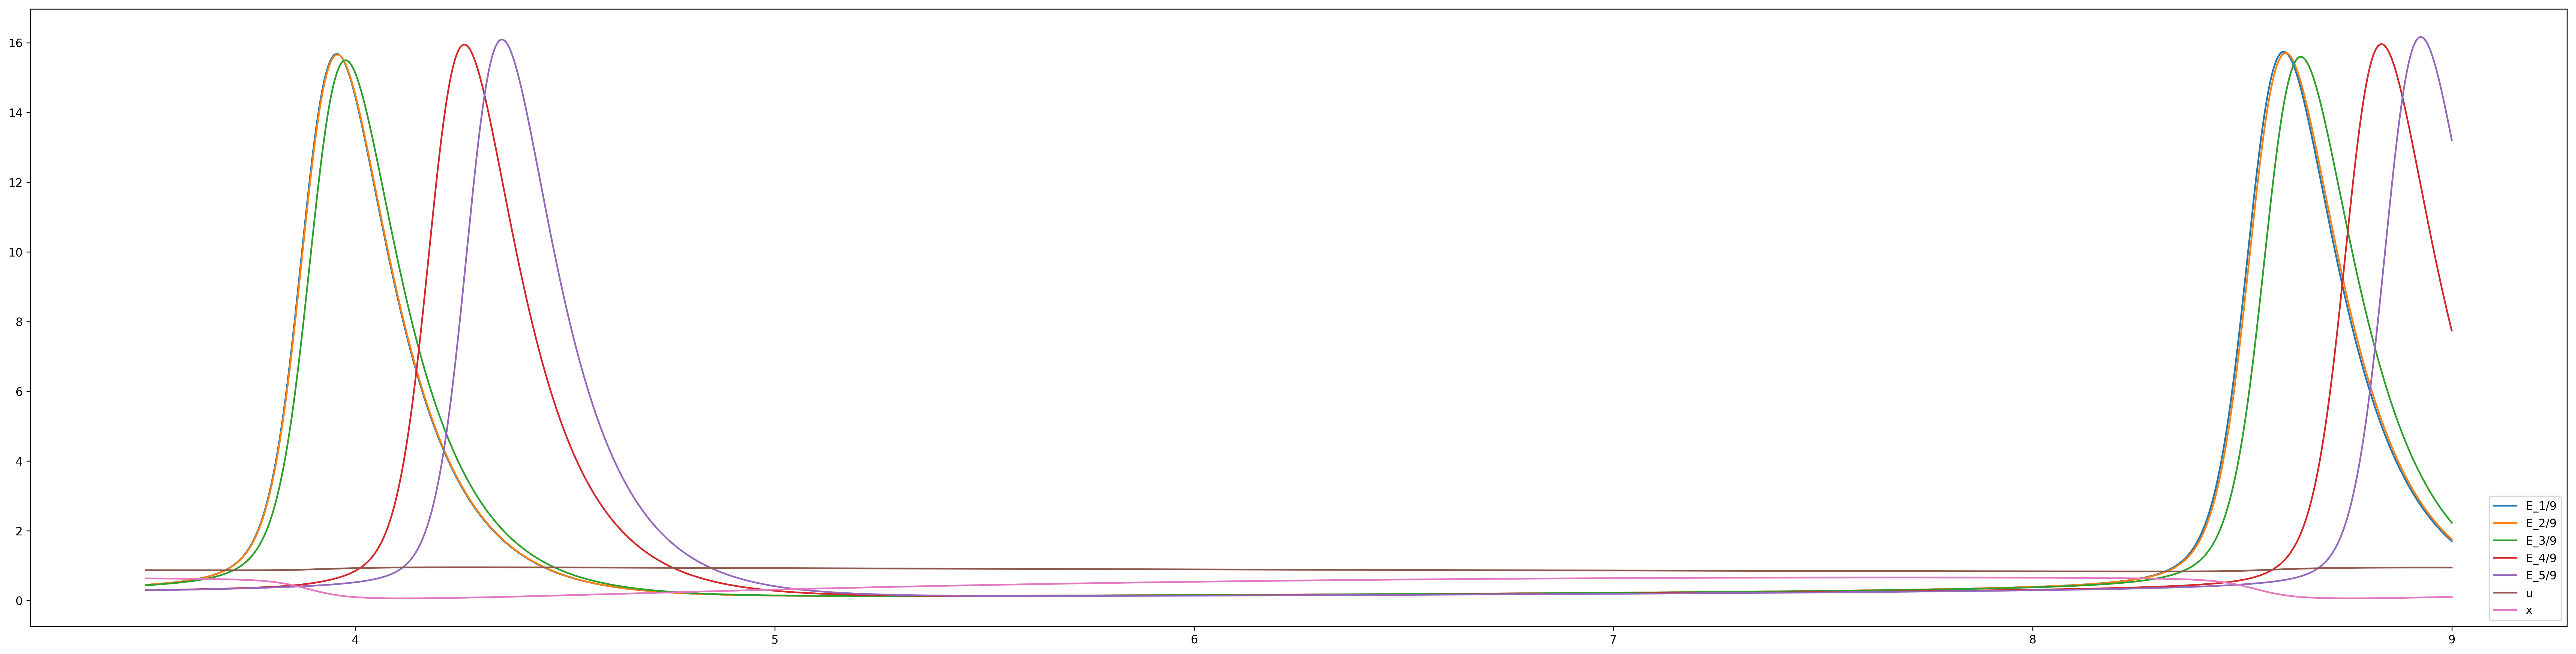

In [104]:
plot_results(300, 3.5, 9)

~0/10 sec completed
~1/10 sec completed
~2/10 sec completed
~3/10 sec completed
~4/10 sec completed
~5/10 sec completed
~6/10 sec completed
~7/10 sec completed
~8/10 sec completed
~9/10 sec completed
finished !


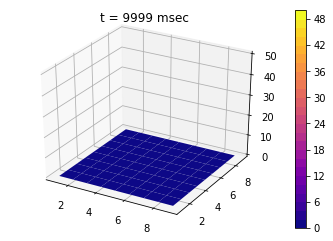

In [100]:
plot_3d_color_surface(10, 0, 'results')

In [112]:
# checking ratio inside current : external current
for i in range(int(T) - 1):
    time[i+1] = i * dt
    i = int(3.8*(1/dt))
    for grid_index_i in range(num_grid):
        for grid_index_j in range(num_grid):
            print("E_t{}{}={}".format(grid_index_i+1, grid_index_j+1, E_t[i, grid_index_i+1,grid_index_j+1]))
            print("inside current {} : external current {}".format(J*u_t[i,grid_index_i+1,grid_index_j+1]*x_t[i,grid_index_i+1,grid_index_j+1]\
                                *E_t[i,grid_index_i+1,grid_index_j+1]\
                                ,c[grid_index_i+1-1, grid_index_j+1, 2] * E_t[i, grid_index_i+1-1, grid_index_j+1]\
                                + c[grid_index_i+1, grid_index_j+1+1, 3] * E_t[i, grid_index_i+1, grid_index_j+1+1]\
                                + c[grid_index_i+1+1, grid_index_j+1, 0] * E_t[i, grid_index_i+1+1, grid_index_j+1]\
                                + c[grid_index_i+1, grid_index_j+1-1, 1] * E_t[i, grid_index_i+1, grid_index_j+1-1]
                                ))
    key = input("progress")

E_t11=3.803417567294395
inside current 2.107073996700948 : external current 1.426281587735398
E_t12=3.803767712889854
inside current 2.1071875057564307 : external current 1.9287460944358654
E_t13=3.863823487139754
inside current 2.126814926098082 : external current 1.9964266224004437
E_t14=3.8635977744115695
inside current 2.126738440335357 : external current 1.9959778377235455
E_t15=3.801259525231713
inside current 2.106340247403776 : external current 1.9243185064575195
E_t16=3.780488098012714
inside current 2.09942675872499 : external current 1.8955137434136529
E_t17=3.776869679750776
inside current 2.0982035999996893 : external current 1.8891931300013685
E_t18=3.7764229346822025
inside current 2.098050788343949 : external current 1.8882561150261266
E_t19=3.776291757853973
inside current 2.0980078509037727 : external current 1.41610940919524
E_t21=3.8030674216989366
inside current 2.1069604728622537 : external current 1.9285879164412116
E_t22=3.9291071738357015
inside current 2.14806

KeyboardInterrupt: 

In [114]:
# param
T = 100 * (1/dt)
num_grid = 9
num_side = 4
scale_factor = 10
c = initialize_c_corner_deleted(num_grid, num_side, scale_factor)

# setting parameter
tau = 0.13
# depressing t_d > t_fac 
# facilitating t_d < t_fac    ++++   prefrontal cortex (PFC) facilitating excitatory connection
t_d = 2
t_fac = 15

t_th = 0.1
thre_effi = 0.02

U = 0.3
E_0_default = -2.3
J = 8
alpha = 0.985

time, E_t, u_t, x_t, z_t = init_dynamical_variable_and_time(num_grid, T, E_ini, u_ini, x_ini, z_ini)
E_t[0, 3:5, 3:5] =20

start_simulation(T, num_grid, time, E_t, u_t, x_t, z_t, J, alpha, tau, E_0_default, t_fac, t_d, t_th, thre_effi, U, dt)

starting sinulation
grid size 9*9 simulation time 100sec
parameters are following
tau 0.13 t_fac 15 t_d 2 t_th 0.1 U 0.3
J 8 alpha 0.985 thre_effi 0.02
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 20. 20.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 20. 20.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
simulation completed !


<Figure size 432x288 with 0 Axes>

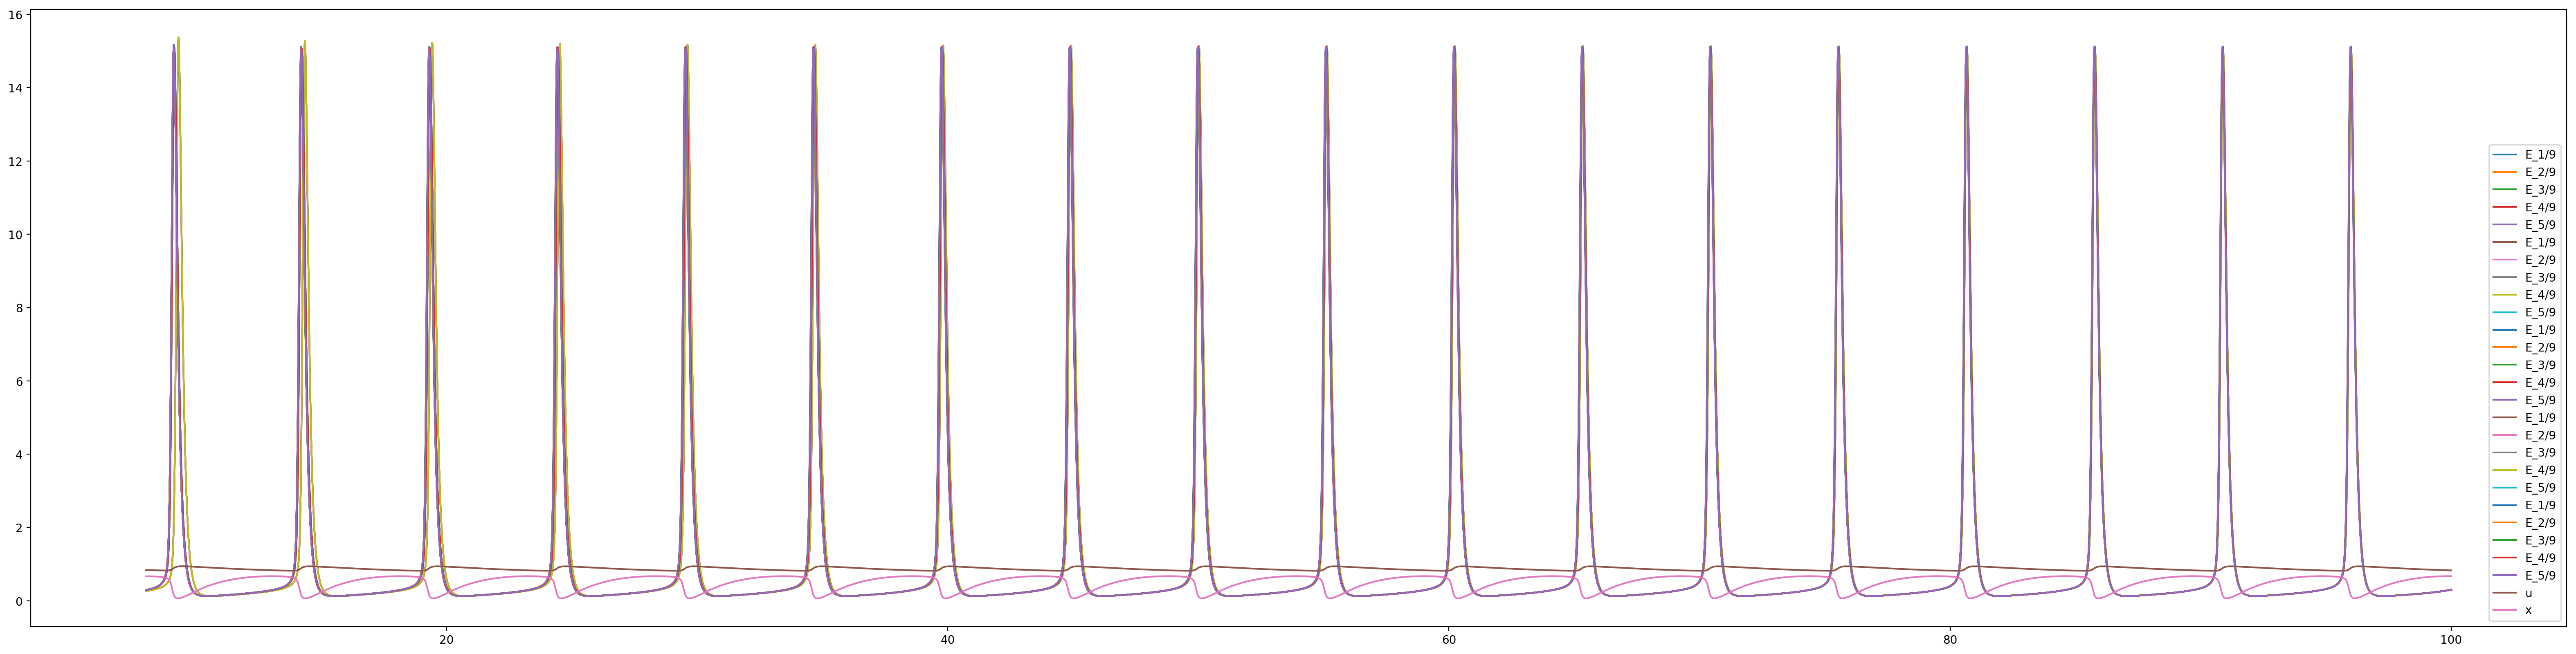

In [117]:
plot_results(200, 8, 100)

~0/10 sec completed
~1/10 sec completed
~2/10 sec completed
~3/10 sec completed
~4/10 sec completed
~5/10 sec completed
~6/10 sec completed
~7/10 sec completed
~8/10 sec completed
~9/10 sec completed
finished !


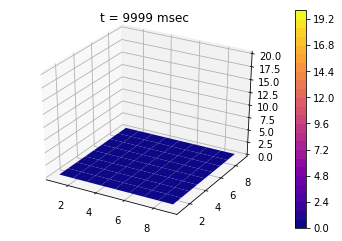

In [119]:
plot_3d_color_surface(10, 80, 'results3')